# What Are Fat Tails? #

Here we discuss some of the theoretical underpinnings of fat-tail distributions, informed mainly by Nassim Taleb in [SCOFT](references.ipynb).

## Thin vs. Fat ##

Probabliity distributions range from thin-tailed to fat-tailed. Taleb formally defines a fat-tailed distribution as a distribution where the tail events dominate its characteristics and impacts. Others refer to this root class as "heavy" tails, reserving "fat" tails for the most dramatic subset.

Taleb suggests "subexponential" distributions as the borderline between thin and fat tails, which are defined in terms of the slope of their survival functions in the tails:
    + the slope of thin-tailed survivial functions (such as the Guassian) decay exponentially towards $\infty$, usually towards some upper bound evident on a log-log plot.
    + the slope of heavy-tailed survival functions decay at a rate slower than exponential, at a minimum, with the more dramatic fat tails decaying linearily (or not decaying at all).
    + Subexponential distributions will have a kurtosis > 3 (kurtosis of Gaussian)

## The Borderline Sigmoid ##

Taleb defines the borderline distribution between thin and fat where the ratio of the power over the root is 1 for a two-tailed distribution:

$$\lim\limits_{x\to+\infty}\frac{F(x)^n}{F(nx)} = 1$$

A sample of such a distribution is suggested as:

$$
F(x) = \frac{1}{2}(1 - tanh(kx)), k > 0
\\ f(x) = \frac{1}{2}ksech^2(kx)
$$

The kurtosis of the above distribution is 4.2, which is greater than 3 (the kurtosis of the standard Gaussian), and so it has slightly fatter tails.


This distribution is available in the package as `BLineSigmoid`. In the figure below, we can see the slightest difference in the head, shoulders, and tail versus the Gaussian.

In [1]:
%load_ext autoreload
%autoreload 2

import seaborn as sns; sns.set(style = 'whitegrid')

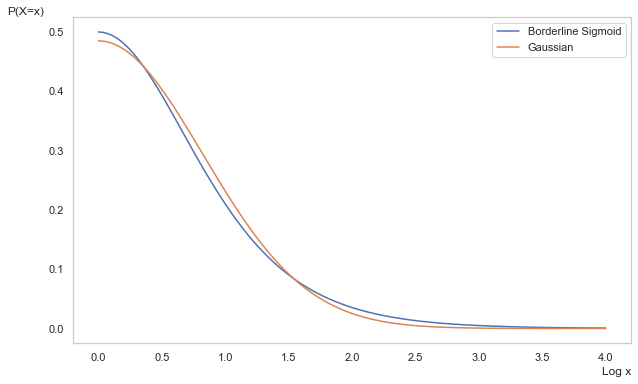

In [2]:
import numpy as np
import scipy.stats as scist
import matplotlib.pyplot as plt

import phat as ph

k = 1
x = np.linspace(0,4,100)
bline = ph.dists.BLineSig(k)
norm = scist.norm(scale=bline.var())

fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(x, bline.pdf(x), label='Borderline Sigmoid')
ax.plot(x, norm.pdf(x) , label='Gaussian')

ax.set_ylabel('P(X=x)', loc='top', rotation='horizontal')
ax.set_xlabel('Log x', loc='right')

plt.legend()

ax.grid(False)
plt.show()

## The Devil is in the Tails ##

So a distribution need only have kurtosis > 3 to be classified as fat-tailed (at least by Taleb). But we can further distinguish between fat tails by the change in slope of the tail as $n\to\infty$. This slope is referred to as the "tail index", designated $\alpha$ by Taleb (and many other greeks by various others).

Thin tails such as the Gaussian have non-linear tails whose slopes decay towards infinity, i.e. $\alpha\to\infty$ as $n\to\infty$, meaning the distributions reach an effective maximum. At this level, E(X | X > x) = X, meaning there are no values $> x$ expected in the distribution.

The more dramatic fat tails tend to a non-zero, non-infinite slope, *meaning they have no effective maximum*. These include the Power Laws. The Power Laws also result in other strange characteristics such as undefined moments including undefined variance ($\alpha < 2$) *and* undefined mean ($\alpha < 1$).

Below we show log-log scales of the Gaussian thin tail versus two subexponential distributions (each with tail index $\alpha = 3$).

+ the Lognormal, which is a fat tail masquerading as a power law and is revealed as an imposter at larger $x$.
+ the Student's T, which is often used as a power law, though it only tends to one at larger $x$.

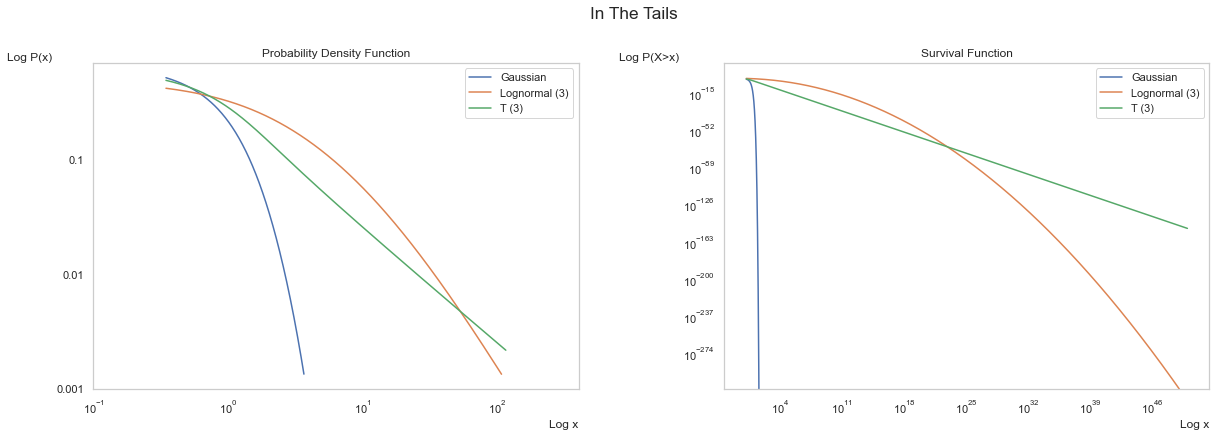

In [11]:
import warnings

k, df = 3, 3
lognorm = scist.lognorm(s=k)
t = scist.t(df=df)

x = np.logspace(.15, 50,10000, dtype=np.float64)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,6))

with np.errstate(divide='ignore'):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax1.plot(np.log(x), -np.log(scist.norm.pdf(x, scale=1)), label='Gaussian')
        ax1.plot(np.log(x), -np.log(lognorm.pdf(x)), label='Lognormal (3)')
        ax1.plot(np.log(x), -np.log(t.pdf(x)), label='T (3)')

ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_xlim((0.1, 400))
ylim = ax1.get_ylim()
ax1.set_ylim(ylim[::-1])

yticks = ax1.get_yticks()
ax1.set_yticks(yticks[2:-2])
ax1.set_yticklabels(1/yticks[2:-2])

ax1.set_ylabel('Log P(x)', loc='top', rotation='horizontal')
ax1.set_xlabel('Log x', loc='right')

ax1.legend()
ax1.set_title('Probability Density Function')

with np.errstate(divide='ignore'):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax2.plot(x, scist.norm.sf(x, scale=1), label='Gaussian')
        ax2.plot(x, lognorm.sf(x), label='Lognormal (3)')
        ax2.plot(x, t.sf(x), label='T (3)')

ax2.set_xscale('log')
ax2.set_yscale('log')

ax2.set_ylabel('Log P(X>x)', loc='top', rotation='horizontal')
ax2.set_xlabel('Log x', loc='right')

ax2.set_title('Survival Function')
ax2.legend()

ax1.grid(False)
ax2.grid(False)

plt.suptitle('In The Tails', y=1.01, size='x-large')
fig.subplots_adjust(wspace=.3)

plt.show()

First, above, we see the PDF of the three distributions with the Gaussian evidencing exponential decay almost immediately, the lognormal decaying into the tails, and the T distribution becoming linear further into the tails. The Survival Function accentuates the difference.

## Scale Invariance ##

The property of a linear slope in the tails of a distribution is known as "scale invariance" (again see [SCOFT](#References)). It means that for a scalar increase in $x$, the probability of occurence decays at a constant rate. Thin-tailed and non-power law fat tails are "scale variant", meaning that the probability of occurence decays at an increasing rate.

This is a remarkably powerful effect, as outcomes far out in the tails of power laws are orders of magnitude *of orders of magnitude* (not a typo) more likely. This is not to say that tail events will occur more often; instead it means that *when tail events do occur, they will be much larger*.

This impact is most readily seen when we decrease the tail index, thereby decreasing the rate of (linear) decay of the survival function, and watch the impact on the first and second moments.

In [12]:
import pandas as pd
alphas = pd.Index([3,2,1], name=r'$\alpha$')
chars = [(scist.pareto(alpha).mean(), scist.pareto(alpha).var()) for alpha in alphas]
df = pd.DataFrame(chars, columns=[r'$\mu$', r'$\sigma^2$'], index=alphas)
df

$\mu$  $\sigma^2$
$\alpha$                   
3           1.5        0.75
2           2.0         inf
1           inf         inf

With a tail index of 2, the potential for extreme values makes the variance undefined. With a tail index of 1 extreme values can be so large that the distribution has no mean.

Scale invariance is mathematically defined as:

$$
P(X>x) = L(x)x^{-a}
$$

where $L(x)$ is a slow-varying function defined as:

$$
\lim\limits_{x\to\infty} \frac{L(cx)}{L(x)} = 1
$$

$L(x)$ can simply be replaced with a constant, as per the Pareto distribution:

$$
P(X>x) = x_{min}x^{-a}
$$

We can see this property of scale invariance most clearly in the table below, where we compare the Gaussian, Lognormal, T, Pareto, and the LogPareto scale ratios at increaseing $k$. This is an expanded version of the table found [SCOFT](references.ipynb).

In [5]:
import pandas as pd

def tail_scale(p, dist):
    return dist.sf(p[1]) / dist.sf(p[0]*p[1])

norm = scist.norm()
lg = scist.lognorm(2)
t = scist.t(2)
pareto = scist.pareto(2)
lp = ph.dists.LogPareto(2)
dists = [norm, lg, t, pareto, lp]

n = [i for i in range(1,5)]
k = [i for i in range(2,16,2)]

index = pd.MultiIndex.from_product([n, k], names=['n', 'k'])

l1 = ['Gaussian', 'Lognorm (2)', "T (2)", 'Pareto (2)', 'Logpareto (2)']
l2 = [r'$P(X > k)^{-1}$', r'$\frac{P(X > k)}{P(X > nk)}$']
cols = pd.MultiIndex.from_product((l1,l2))

distcomp = pd.DataFrame([], index=index, columns=cols)
distcomp = distcomp.sort_values(['n', 'k'])

with np.errstate(divide='ignore'):
    for dist, l in zip(dists, l1):
        distcomp.loc[:, (l, l2[0])] = [1 / dist.sf(p[1]) for p in index]
        distcomp.loc[:, (l, l2[1])] = [tail_scale(p, dist) for p in index]

cols_arr = np.array([[j for j in i] for i in distcomp.columns.to_numpy()])
fmt1 = {tuple(col): "{:,.0E}" for col in distcomp.columns[:2]}
fmt2 = {tuple(col): "{:,.0f}" for col in distcomp.columns[[4, 6, 7]]}
fmt3 = {tuple(col): "{:,.1f}" for col in distcomp.columns[[5, 8, 9]]}

distcomp.style.format({**fmt1, **fmt2, **fmt3})

Focusing on the $\frac{P(X>k)}{P(X>nk}$ column, we can see dramatic differences between the distributions:

+ Pareto: For each `n`, the value of `k` has *no impact on the ratio*. It is stable, regardless of the value of `k` used. This is the "scale invariance" described above.
+ Gaussian: the complete opposite occurs, with the ratio exploding higher for minor increments of `k`.
+ Lognormal / Student's T: the ratio for both increases much slower than the Gaussian, but still does not reach a stable value until deep into the tails. Hence, the drawback of using Student's T as a substitute for power laws and why significant literature has been devoted to use of the generalized Pareto. We can see this visually below.

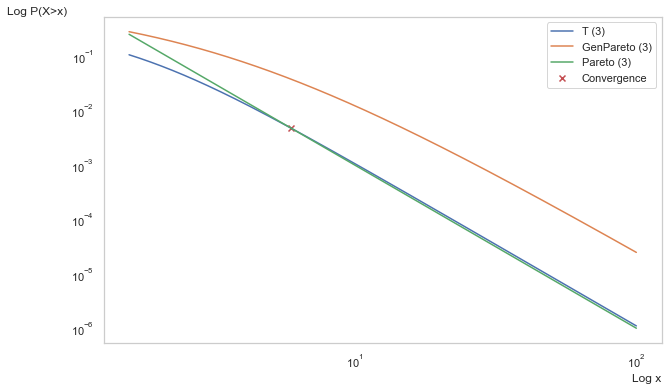

In [6]:
x = np.logspace(.2, 2, 100000, dtype=np.float64)
t = scist.t(3)
pareto = scist.pareto(3)
gp = scist.genpareto(1/3)
convergence = np.isclose(t.sf(x), pareto.sf(x), atol=0.000001).argmax()

fig, ax2 = plt.subplots(1,1,figsize=(10,6))

ax2.plot(x, t.sf(x), label='T (3)')
ax2.plot(x, gp.sf(x), label='GenPareto (3)')
ax2.plot(x, pareto.sf(x), label='Pareto (3)')

ax2.scatter(
    x[convergence], 
    t.sf(x[convergence]), 
    c='C3', marker='x', alpha=1,
    label='Convergence'
)

ax2.set_xscale('log')
ax2.set_yscale('log')

ax2.set_ylabel('Log P(X>x)', loc='top', rotation='horizontal')
ax2.set_xlabel('Log x', loc='right')

ax2.legend()

ax2.grid(False)

plt.show()

+ meanwhile, the LogPareto is not only scale invariant at large $k$, it is also invariant to $n$!!! Or at least it tends there over time. This means as $\alpha\to0$ as $x\to\infty$, which can be seen below.

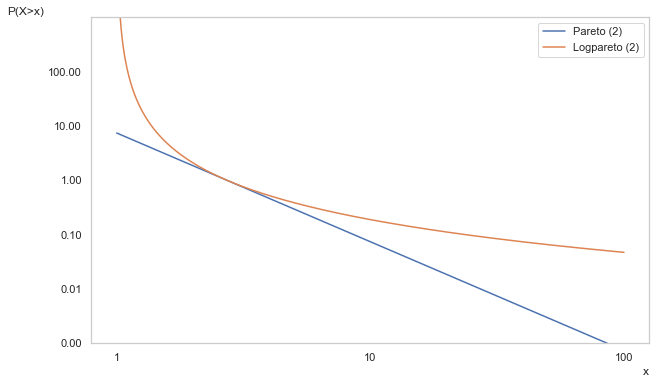

In [8]:
import matplotlib.ticker as mticks

alpha = 2
L = 1
pareto = scist.pareto(alpha, scale=L)
lp = ph.dists.LogPareto(alpha=alpha, L=L)
x = np.linspace(1, 100,10000)

fig, ax = plt.subplots(figsize=(10,6))

with np.errstate(divide='ignore'):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax.plot(x, pareto.sf(x)*np.exp(alpha), label='Pareto (2)')
        ax.plot(x, lp.sf(x), label='Logpareto (2)')

ax.set_xscale('log')
ax.set_yscale('log')
yticks = 10**np.arange(-3,3).astype('float')
ax.set_yticks(yticks)
ax.set_yticklabels(1/yticks[3:-3])
ax.set_ylim((10**-3, 10**3))

ax.xaxis.set_major_formatter(mticks.StrMethodFormatter('{x:.0f}'))
ax.yaxis.set_major_formatter(mticks.StrMethodFormatter('{x:.2f}'))

ax.set_ylabel('P(X>x)', loc='top', rotation='horizontal')
ax.set_xlabel('x', loc='right')

ax.legend()
ax.grid(False)

plt.show()

## Six Sigma is Not Six Sigma ##

The impact of fat tails is readily observable in daily equity returns. In a Gaussian distribtion, a "Six Sigma" event (i.e. one that is 6 standard deviations from the mean) [should occur](https://arxiv.org/pdf/1103.5672.pdf) two in every  $10^9$ samples. For daily equity returns, this translates into a Six Sigma event occuring ***every ~4 million years***. By contrast, a Six Sigma event in the Pareto should occur once every ***36 days***.

In [13]:
n_years_gauss = (1 / scist.norm.sf(6)) / 252
n_days_pareto = (1/scist.pareto(2).sf(6))
print (f'Guassian: {n_years_gauss:,.0f} years')
print (f'Pareto: {n_days_pareto:.0f} days')

Guassian: 4,022,201 years
Pareto: 36 days


We are fed Black-Sholes and Guassian-based volatility for option pricing for much of our lives. And yet if you are just 10 years old, you've lived long enough to see a Six Sigma event in the US equity market. And if you've lived 80 years, well ... 

Below we show the occurrences of Six Sigma events in the S&P 500 over various timeframes. Each time the blue line breaches the red dotted line, that is a 2-in-4M year occurence according to the Gaussian.

In [10]:
import yfinance as yf

sp = yf.download('^GSPC')
sp_ret = sp.Close.pct_change()[1:]

[*********************100%***********************]  1 of 1 completed


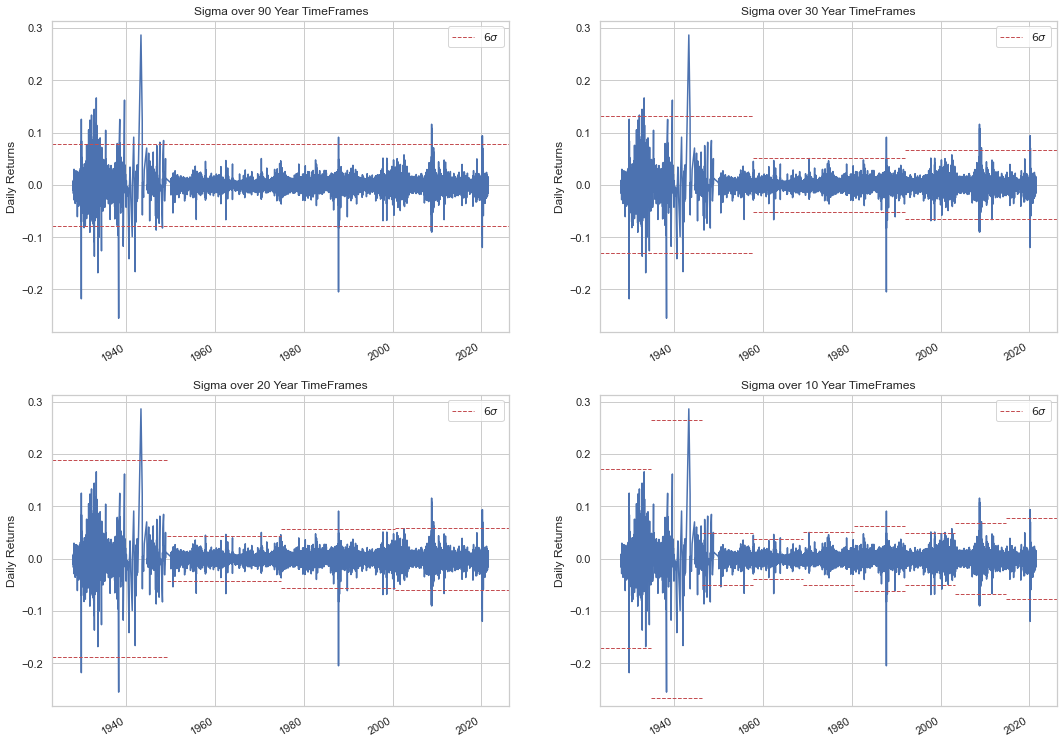

In [11]:
from datetime import datetime as dt

fig, axs = plt.subplots(2,2, figsize=(18,14))
axs = axs.flatten()

rngs = np.arange(30, 0, -10)
rngs = np.concatenate(([90], rngs))
titles = [f'Sigma over {rng} Year TimeFrames' for rng in rngs]
for i in range(4):
    sp_ret.plot(ax=axs[i])

    yrs = np.arange(sp_ret.index.min().year, sp_ret.index.max().year, rngs[i])
    yrs = np.array([dt(yr, 1, 1) for yr in yrs])

    ranges = np.vstack((yrs[:-1], yrs[1:])).T

    stds = []
    for rng in ranges:
        sp_split = sp_ret[slice(*rng)]
        mean, std = scist.norm.fit(sp_split)
        stds.append(std)

    cum = np.concatenate((np.zeros(1), np.repeat(1 / len(stds), len(stds)).cumsum()))
    trng = np.vstack((cum[:-1], cum[1:])).T
    for j in range(len(stds)):
        sig = axs[i].axhline(stds[j]*6, *trng[j], c='C3', ls='--', lw=1, label=r'$6\sigma$')
        signeg = axs[i].axhline(-stds[j]*6, *trng[j], c='C3', ls='--', lw=1, label=r'$-6\sigma$')

    axs[i].set_xlabel('')
    axs[i].set_ylabel('Daily Returns')
    axs[i].legend(handles=[sig])
    axs[i].set_title(titles[i])
plt.show()

To paraphrase Taleb:

> If you see a 6 sigma event, that's not a 6 sigma event.

Daily equity returns are clearly ***not*** Gaussian, which has one major implication: Geometric Brownian Motion is not appropriate for share prices and by extension the Black-Scholes pricing model is utterly invalid. 